In [1]:
import os
print(os.environ["JAVA_HOME"])
print(os.environ["SPARK_HOME"])
print(os.environ["PYTHONPATH"])

/Library/Java/JavaVirtualMachines/jdk1.8.0_191.jdk/Contents/Home
/usr/local/Cellar/apache-spark/2.3.2/libexec/
/usr/local/Cellar/apache-spark/2.3.2/libexec//python/lib/py4j-0.10.7-src.zip:/usr/local/Cellar/apache-spark/2.3.2/libexec//python/:


In [43]:
import pandas as pd
import numpy as np

np.set_printoptions(threshold=np.inf)
import scipy as sp
import json
#import PIL.Image
from PIL import ImageStat
import math


import cv2

from matplotlib import pyplot as plt


from pyspark.sql import *
from pyspark.sql.functions import *


from pyspark.ml.image import ImageSchema

from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.types import *


import shutil

from pandas.io.json import json_normalize
from pandas.io.json import build_table_schema

from PIL import Image



IMAGE_DIR = "./data/"




In [3]:
spark = SparkSession.builder.getOrCreate()

In [6]:
elyseemusee_image_df = ImageSchema.readImages(IMAGE_DIR + "/elyseemusee" , recursive=False, dropImageFailures=True).withColumn("label", lit(1))
# + "/elyseemusee"
elyseemusee_image_df = elyseemusee_image_df.withColumn("id", monotonically_increasing_id())
#elyseemusee_image_df = elyseemusee_image_df.withColumn("filename", regexp_extract("image.origin", "elyseemusee\/(.*)", 0))
elyseemusee_image_df = elyseemusee_image_df.withColumn("filename", regexp_extract("image.origin", "(?<=elyseemusee\/).*", 0))


elyseemusee_image_df.printSchema()
elyseemusee_image_df.count()

#elyseemusee_image_df.show(1)



root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: integer (nullable = false)
 |-- id: long (nullable = false)
 |-- filename: string (nullable = true)



389

In [7]:
renaming_df = elyseemusee_image_df.select('filename', 'id')
renaming_df = renaming_df.toPandas()

renaming_df.head(3)



,filename,id
0,36086569_432136177259620_682820613751963648_n.jpg,0
1,35134811_367791753745345_4832669035063672832_n...,1
2,30855238_168025870569215_8629331536732225536_n...,2


In [8]:
tag_elyseemusee_path = IMAGE_DIR + 'elyseemusee/' 
rename_test_path = IMAGE_DIR + '/test/'
rename_elyseemusee_800_path = IMAGE_DIR + '/elyseemusee_800/'
rename_elyseemusee_400_path = IMAGE_DIR + '/elyseemusee_400/'

In [176]:
### Duplicate and rename elysee images, save to elyseemusee_400



def copy_rename(old_file_name, new_file_name):
        new_file_name = str(new_file_name)
        #src_dir= os.path.join(os.curdir, '/data/elyseemusee/')
        #dst_dir= os.path.join(os.curdir , '/data/elyseemusee_800')
        #src_file = tag_elyseemusee_path + old_file_name
        shutil.copy(tag_elyseemusee_path + old_file_name, rename_elyseemusee_400_path)
        
        dst_file = os.path.join(rename_elyseemusee_400_path, old_file_name)
        new_dst_file_name = rename_elyseemusee_400_path + new_file_name + '.jpg'
        os.rename(dst_file, new_dst_file_name)

In [177]:


for index, row in renaming_df.iterrows():
    copy_rename(row['filename'], row['id'])
   #print (row['filename'], row['id'])


## Test code for duplicating and renaming images
# shutil.copy(tag_elyseemusee_path + '34771934_343134552878265_8019941514983505920_n.jpg', rename_test_path)

# dst_file = os.path.join(rename_test_path, '34771934_343134552878265_8019941514983505920_n.jpg')

# new_dst_file_name = os.path.join(rename_test_path, '4.jpg')

# os.rename(dst_file, new_dst_file_name)


    


In [179]:
# resize to 800 x 800

#elyseemusee_800_image_df = ImageSchema.readImages(IMAGE_DIR + "/elyseemusee_800" , recursive=False, dropImageFailures=True)

#elyseemusee_800_image_df.select(resizeImage((800, 800))('image'))

# image_name = rename_elyseemusee_800_path + '/1.jpg'
# new_size = 800
# im = Image.open(image_name)
# width, height = im.size   # Get dimensions
# print ('ORIGINAL SIZE: ', im.size)
# new_width = new_height = new_size
# left = (width - new_width)/2
# top = (height - new_height)/2
# right = (width + new_width)/2
# bottom = (height + new_height)/2

# cr = im.crop((left, top, right, bottom))
# cr.save(rename_elyseemusee_800_path + '1_test.jpg','jpeg')
# print ('CROPPED SIZE: ', cr.size)

    
def crop(image_name, new_size):
    im = Image.open(image_name)
    width, height = im.size   # Get dimensions
    new_width = new_height = new_size
    if width > new_size or height > new_size:
        left = 0
        right = width
        bottom = height
        top = 0
        
        if width > new_size:
            left = (width - new_width)/2
            right = (width + new_width)/2
        if height > new_size:
            top = (height - new_height)/2
            bottom = (height + new_height)/2
        im = im.crop((left, top, right, bottom))
        ## resize to 400
    im.thumbnail([400, 400], Image.ANTIALIAS)

    im.save(image_name, 'jpeg')

#crop(rename_elyseemusee_800_path + '/1.jpg', 800)
        

path = rename_elyseemusee_400_path
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if item.endswith('.jpg'):
            fullpath = os.path.join(path, item)
            if os.path.isfile(fullpath):
                #print(fullpath)
                #im = Image.open(fullpath)
                #f, e = os.path.splitext(fullpath)

                crop(fullpath, 800)

resize()






In [92]:
### Duplicate and rename elysee images, save to elyseemusee_200
tag_elyseemusee_path = IMAGE_DIR + 'elyseemusee/' 
rename_test_path = IMAGE_DIR + '/test/'
rename_elyseemusee_200_path = IMAGE_DIR + '/elyseemusee_200/'

def copy_rename(old_file_name, new_file_name):
        new_file_name = str(new_file_name)
        
        shutil.copy(tag_elyseemusee_path + old_file_name, rename_elyseemusee_200_path)
        
        dst_file = os.path.join(rename_elyseemusee_200_path, old_file_name)
        new_dst_file_name = rename_elyseemusee_200_path + new_file_name + '.jpg'
        os.rename(dst_file, new_dst_file_name)
        
for index, row in renaming_df.iterrows():
    copy_rename(row['filename'], row['id'])


# resize (not crop) to 200 x 200
def crop(image_name, new_size):
    im = Image.open(image_name)
    im.thumbnail([200, 200], Image.ANTIALIAS)
    im.save(image_name, 'jpeg')

#crop(rename_elyseemusee_800_path + '/1.jpg', 800)
        

path = rename_elyseemusee_200_path
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if item.endswith('.jpg'):
            fullpath = os.path.join(path, item)
            if os.path.isfile(fullpath):
                #print(fullpath)
                #im = Image.open(fullpath)
                #f, e = os.path.splitext(fullpath)

                crop(fullpath, 200)

resize()




In [9]:
### Merge metadata for elysee
tag_elyseemusee_json_data = json.load(open(tag_elyseemusee_path + 'elyseemusee.json'))

elyseemusee_meta_df = pd.DataFrame.from_dict(json_normalize(tag_elyseemusee_json_data), orient='columns')

elyseemusee_meta_df.head(5)
elyseemusee_meta_df = elyseemusee_meta_df.rename(index=str, columns={"id": "insta_id"})
build_table_schema(elyseemusee_meta_df)

schema = StructType([
    #StructField("index", StringType(), True),
    StructField("comments_disabled", StringType(), True), 
    StructField("dimensions.height", IntegerType(), True), 
    StructField("dimensions.width", IntegerType(), True),
    StructField("display_url", StringType(), True),
    StructField("edge_liked_by.count", IntegerType(), True),
    StructField("edge_media_preview_like.count", IntegerType(), True),
    StructField("edge_media_to_caption.edges", StringType(), True),
    StructField("edge_media_to_comment.count", IntegerType(), True),
    StructField("insta_id", StringType(), True),
    StructField("is_video", BooleanType(), True),
    StructField("owner.id", StringType(), True),
    StructField("shortcode", StringType(), True),
    StructField("tags", StringType(), True),
    StructField("taken_at_timestamp", IntegerType(), True),
    StructField("thumbnail_resources", StringType(), True),
    StructField("thumbnail_src", StringType(), True),
    StructField("urls", StringType(), True), 
    StructField("video_view_count", StringType(), True)
])

elyseemusee_meta_spark_df = spark.createDataFrame(elyseemusee_meta_df, schema)
elyseemusee_meta_spark_df = elyseemusee_meta_spark_df.withColumn("meta_filename", regexp_extract("display_url", "([^/]+$)", 0))


elyseemusee_meta_spark_df.head(3)


[Row(comments_disabled=u'NaN', dimensions.height=1080, dimensions.width=1080, display_url=u'https://scontent-frt3-1.cdninstagram.com/vp/9d067ad3e56414b0a69e83165a10d82c/5C85D4F0/t51.2885-15/e35/s1080x1080/43914187_191002591798716_9125298468695310336_n.jpg', edge_liked_by.count=41, edge_media_preview_like.count=41, edge_media_to_caption.edges=u'[{node={text=#elyseemusee #beautifulautomn#automn#work#pasmallavue#emerveillementquotidien#sun#color#colorful#light#sunnyday#eteindien#\U0001f341#musee#photography#lightintheair#nofilter}}]', edge_media_to_comment.count=3, insta_id=u'1897362865096333903', is_video=False, owner.id=u'4092504323', shortcode=u'BpUyXkgFZpP', tags=u'[work, eteindien, sunnyday, musee, photography, light, sun, nofilter, lightintheair, color, pasmallavue, emerveillementquotidien, elyseemusee, automn, colorful, beautifulautomn]', taken_at_timestamp=1540403300, thumbnail_resources=u'[{config_height=150, src=https://scontent-frt3-1.cdninstagram.com/vp/011afe228595f71718975df

In [94]:
elyseemusee_image_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: integer (nullable = false)
 |-- id: long (nullable = false)
 |-- filename: string (nullable = true)



In [10]:
elyseemusee_id_ogname_map = renaming_df
elyseemusee_id_ogname_map['id_jpg'] = elyseemusee_id_ogname_map['id'].apply(lambda x: "{}{}".format(x, '.jpg'))

elyseemusee_id_ogname_map_spark = spark.createDataFrame(elyseemusee_id_ogname_map)
elyseemusee_id_ogname_map_spark = elyseemusee_id_ogname_map_spark.drop("id")

elyseemusee_id_ogname_map_spark.count()
elyseemusee_id_ogname_map_spark.head(3)


[Row(filename=u'36086569_432136177259620_682820613751963648_n.jpg', id_jpg=u'0.jpg'),
 Row(filename=u'35134811_367791753745345_4832669035063672832_n.jpg', id_jpg=u'1.jpg'),
 Row(filename=u'30855238_168025870569215_8629331536732225536_n.jpg', id_jpg=u'2.jpg')]

In [11]:
elyseemusee_image_df = elyseemusee_image_df.join(elyseemusee_meta_spark_df, elyseemusee_image_df.filename == elyseemusee_meta_spark_df.meta_filename)
# drop the rest of the image data, especially the bytes - just keep the metadata and mapping from image name to id
#inner_join.show(10)

elyseemusee_image_df.printSchema()



root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: integer (nullable = false)
 |-- id: long (nullable = false)
 |-- filename: string (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- dimensions.height: integer (nullable = true)
 |-- dimensions.width: integer (nullable = true)
 |-- display_url: string (nullable = true)
 |-- edge_liked_by.count: integer (nullable = true)
 |-- edge_media_preview_like.count: integer (nullable = true)
 |-- edge_media_to_caption.edges: string (nullable = true)
 |-- edge_media_to_comment.count: integer (nullable = true)
 |-- insta_id: string (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- owner.id: string (nullable = true)
 |-- shortcode: string (nullable = t

In [12]:
elyseemusee_simplified_df = elyseemusee_image_df.drop("image", "label", "comments_disabled", "is_video", "thumbnail_resources", "thumbnail_src", "video_view_count")


elyseemusee_simplified_df.printSchema()
elyseemusee_simplified_df.head(2)


root
 |-- id: long (nullable = false)
 |-- filename: string (nullable = true)
 |-- dimensions.height: integer (nullable = true)
 |-- dimensions.width: integer (nullable = true)
 |-- display_url: string (nullable = true)
 |-- edge_liked_by.count: integer (nullable = true)
 |-- edge_media_preview_like.count: integer (nullable = true)
 |-- edge_media_to_caption.edges: string (nullable = true)
 |-- edge_media_to_comment.count: integer (nullable = true)
 |-- insta_id: string (nullable = true)
 |-- owner.id: string (nullable = true)
 |-- shortcode: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- taken_at_timestamp: integer (nullable = true)
 |-- urls: string (nullable = true)
 |-- meta_filename: string (nullable = true)



[Row(id=228, filename=u'10387845_1047886545275280_349237471_n.jpg', dimensions.height=1080, dimensions.width=1080, display_url=u'https://scontent-frt3-1.cdninstagram.com/vp/4d9b432b02ee9903809113a1d102dc82/5C516441/t51.2885-15/e35/10387845_1047886545275280_349237471_n.jpg', edge_liked_by.count=25, edge_media_preview_like.count=25, edge_media_to_caption.edges=u'[{node={text=#museedelelysee #lausanne #switzerland #photography101 #minimal #graphic #blackandwhite #blackandwhitephotography #elyseemusee #architecture}}]', edge_media_to_comment.count=2, insta_id=u'1190589815359605892', owner.id=u'330008394', shortcode=u'BCF0yEJtQyE', tags=u'[switzerland, minimal, lausanne, blackandwhite, museedelelysee, graphic, blackandwhitephotography, photography101, architecture, elyseemusee]', taken_at_timestamp=1456149387, urls=u'[https://scontent-frt3-1.cdninstagram.com/vp/4d9b432b02ee9903809113a1d102dc82/5C516441/t51.2885-15/e35/10387845_1047886545275280_349237471_n.jpg]', meta_filename=u'10387845_104

In [180]:
# not needed if not using spark
### elysee_200 resized image and metadata join

# elyseemusee_image_200_df = ImageSchema.readImages(IMAGE_DIR + "/elyseemusee_200" , recursive=False, dropImageFailures=True)
# elyseemusee_image_200_df = elyseemusee_image_200_df.withColumn("filename_200", regexp_extract("image.origin", "(?<=elyseemusee_200\/).*", 0))
# elyseemusee_image_200_df.count()
# elyseemusee_image_200_df.printSchema()
# #elyseemusee_image_200_df.head(2)

# elyseemusee_simplified_df.printSchema()
# #elyseemusee_simplified_df.head(2)





root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- filename_200: string (nullable = true)

root
 |-- filename: string (nullable = true)
 |-- id: long (nullable = false)
 |-- dimensions.height: integer (nullable = true)
 |-- dimensions.width: integer (nullable = true)
 |-- display_url: string (nullable = true)
 |-- edge_liked_by.count: integer (nullable = true)
 |-- edge_media_preview_like.count: integer (nullable = true)
 |-- edge_media_to_caption.edges: string (nullable = true)
 |-- edge_media_to_comment.count: integer (nullable = true)
 |-- insta_id: string (nullable = true)
 |-- owner.id: string (nullable = true)
 |-- shortcode: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- taken_at_timestamp: integer (null

In [145]:
#elyseemusee_image_200_df.head(1)


[Row(image=Row(origin='file:/Users/mikejiao/OneDrive - University of Waterloo/School/Fall 2018 Exchange/EPFL/EXD/instagram/instagrammability/data/elyseemusee_200/63.jpg', height=133, width=200, nChannels=3, mode=16, data=bytearray(b'\x8d\x8d\x8d\x84\x84\x84\x8e\x8e\x8e~~~\x89\x89\x89\x84\x84\x84\x88\x88\x88\x87\x87\x87\x89\x89\x89\x88\x88\x88\x88\x88\x88\x89\x89\x89\x8a\x8a\x8a\x89\x89\x89\x89\x89\x89\x8a\x8a\x8a\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x88\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89\x89

In [13]:
#elyseemusee_simplified_df.join(elyseemusee_image_200_df, elyseemusee_image_200_df.filename_200 == elyseemusee_simplified_df.filename)
elyseemusee_simplified_df = elyseemusee_simplified_df.join(elyseemusee_id_ogname_map_spark, "filename")

#elyseemusee_simplified_df = elyseemusee_simplified_df.join(elyseemusee_image_200_df, elyseemusee_image_200_df.filename == elyseemusee_simplified_df.id_jpg)

elyseemusee_simplified_df.printSchema()




root
 |-- filename: string (nullable = true)
 |-- id: long (nullable = false)
 |-- dimensions.height: integer (nullable = true)
 |-- dimensions.width: integer (nullable = true)
 |-- display_url: string (nullable = true)
 |-- edge_liked_by.count: integer (nullable = true)
 |-- edge_media_preview_like.count: integer (nullable = true)
 |-- edge_media_to_caption.edges: string (nullable = true)
 |-- edge_media_to_comment.count: integer (nullable = true)
 |-- insta_id: string (nullable = true)
 |-- owner.id: string (nullable = true)
 |-- shortcode: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- taken_at_timestamp: integer (nullable = true)
 |-- urls: string (nullable = true)
 |-- meta_filename: string (nullable = true)
 |-- id_jpg: string (nullable = true)



In [184]:
### abandon spark, too heavy
# elyseemusee_simplified_df = elyseemusee_simplified_df.join(elyseemusee_image_200_df, elyseemusee_image_200_df.filename_200 == elyseemusee_simplified_df.id_jpg)

# elyseemusee_simplified_df.printSchema()

root
 |-- filename: string (nullable = true)
 |-- id: long (nullable = false)
 |-- dimensions.height: integer (nullable = true)
 |-- dimensions.width: integer (nullable = true)
 |-- display_url: string (nullable = true)
 |-- edge_liked_by.count: integer (nullable = true)
 |-- edge_media_preview_like.count: integer (nullable = true)
 |-- edge_media_to_caption.edges: string (nullable = true)
 |-- edge_media_to_comment.count: integer (nullable = true)
 |-- insta_id: string (nullable = true)
 |-- owner.id: string (nullable = true)
 |-- shortcode: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- taken_at_timestamp: integer (nullable = true)
 |-- urls: string (nullable = true)
 |-- meta_filename: string (nullable = true)
 |-- id_jpg: string (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 | 

In [14]:
elyseemusee_simplified_df.count()

330

In [32]:
#convert image data into a format openCV can work with
#iterate openCV methods over dataframe, getting hue, vaturation, value histogram vectors
    ## https://www.linkedin.com/pulse/jupyter-notebooks-satellite-imagery-andrew-cutts/
# https://stackoverflow.com/questions/16895135/getting-dominance-color-opencv
# https://stackoverflow.com/questions/5906693/how-to-reduce-the-number-of-colors-in-an-image-with-opencv

#https://en.wikipedia.org/wiki/Quantization_%28image_processing%29
elyseemusee_simplified_pd_df = elyseemusee_simplified_df.toPandas()
elyseemusee_simplified_pd_df.head(3)

,filename,id,dimensions.height,dimensions.width,display_url,edge_liked_by.count,edge_media_preview_like.count,edge_media_to_caption.edges,edge_media_to_comment.count,insta_id,owner.id,shortcode,tags,taken_at_timestamp,urls,meta_filename,id_jpg
0,10387845_1047886545275280_349237471_n.jpg,228,1080,1080,https://scontent-frt3-1.cdninstagram.com/vp/4d...,25,25,[{node={text=#museedelelysee #lausanne #switze...,2,1190589815359605892,330008394,BCF0yEJtQyE,"[switzerland, minimal, lausanne, blackandwhite...",1456149387,[https://scontent-frt3-1.cdninstagram.com/vp/4...,10387845_1047886545275280_349237471_n.jpg,228.jpg
1,11111368_1566281886957477_1576784619_n.jpg,153,612,612,https://scontent-frt3-1.cdninstagram.com/vp/73...,34,34,[{node={text=Federal Law Enforcement Storage U...,0,950554374556800253,1262267484,0xDCrbJtT9,"[annabelelgar, bpfir, elyseemusee, prixelysee]",1427534933,[https://scontent-frt3-1.cdninstagram.com/vp/7...,11111368_1566281886957477_1576784619_n.jpg,153.jpg
2,42004243_548605342236981_385180074925040859_n.jpg,12,1080,1080,https://scontent-frt3-1.cdninstagram.com/vp/36...,21,21,[{node={text=#reflet #grille #lumiere #rond #m...,1,1874303303963997783,695944864,BoC3OyqHXZX,"[nuitdesmusees, musee, jeandubuffet, reflet, l...",1537654386,[https://scontent-frt3-1.cdninstagram.com/vp/3...,42004243_548605342236981_385180074925040859_n.jpg,12.jpg


In [33]:
elyseemusee_simplified_pd_df = elyseemusee_simplified_pd_df.drop(columns=["meta_filename"])
elyseemusee_simplified_pd_df.head(3)

,filename,id,dimensions.height,dimensions.width,display_url,edge_liked_by.count,edge_media_preview_like.count,edge_media_to_caption.edges,edge_media_to_comment.count,insta_id,owner.id,shortcode,tags,taken_at_timestamp,urls,id_jpg
0,10387845_1047886545275280_349237471_n.jpg,228,1080,1080,https://scontent-frt3-1.cdninstagram.com/vp/4d...,25,25,[{node={text=#museedelelysee #lausanne #switze...,2,1190589815359605892,330008394,BCF0yEJtQyE,"[switzerland, minimal, lausanne, blackandwhite...",1456149387,[https://scontent-frt3-1.cdninstagram.com/vp/4...,228.jpg
1,11111368_1566281886957477_1576784619_n.jpg,153,612,612,https://scontent-frt3-1.cdninstagram.com/vp/73...,34,34,[{node={text=Federal Law Enforcement Storage U...,0,950554374556800253,1262267484,0xDCrbJtT9,"[annabelelgar, bpfir, elyseemusee, prixelysee]",1427534933,[https://scontent-frt3-1.cdninstagram.com/vp/7...,153.jpg
2,42004243_548605342236981_385180074925040859_n.jpg,12,1080,1080,https://scontent-frt3-1.cdninstagram.com/vp/36...,21,21,[{node={text=#reflet #grille #lumiere #rond #m...,1,1874303303963997783,695944864,BoC3OyqHXZX,"[nuitdesmusees, musee, jeandubuffet, reflet, l...",1537654386,[https://scontent-frt3-1.cdninstagram.com/vp/3...,12.jpg


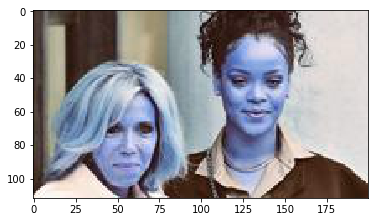

In [208]:
img_bgr_test = cv2.imread(rename_elyseemusee_200_path + '2.jpg')
plt.imshow(img_bgr_test)
plt.show()

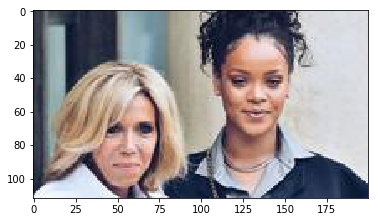

In [209]:
img_rgb_test = cv2.cvtColor(img_bgr_test, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_test)
plt.show()

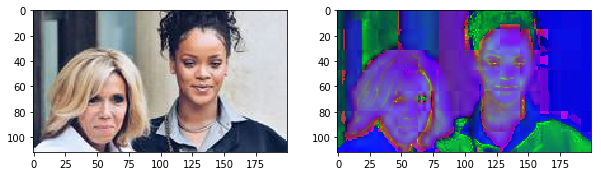

In [210]:
img_hsv_test = cv2.cvtColor(img_rgb_test,cv2.COLOR_BGR2HSV)## convert to HSV

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb_test)

plt.subplot(1, 2, 2)
plt.imshow(img_hsv_test)

plt.show()


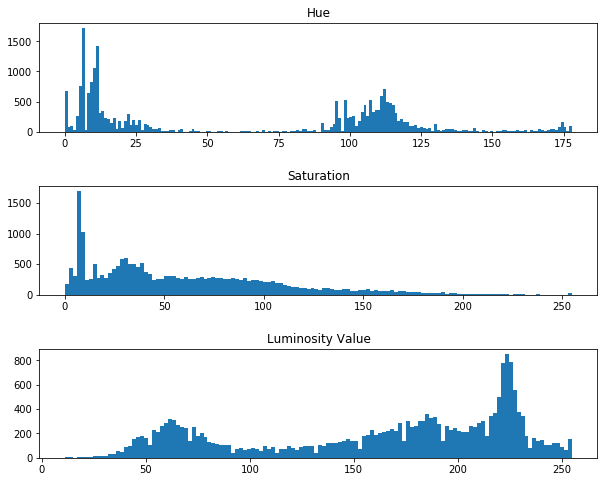

In [211]:
hue, sat, val = img_hsv_test[:,:,0], img_hsv_test[:,:,1], img_hsv_test[:,:,2]

plt.figure(figsize=(10,8))
plt.subplot(311)                             #plot in the first cell
plt.subplots_adjust(hspace=.5)
plt.title("Hue")
plt.hist(np.ndarray.flatten(hue), bins=180)
plt.subplot(312)                             #plot in the second cell
plt.title("Saturation")
plt.hist(np.ndarray.flatten(sat), bins=128)
plt.subplot(313)                             #plot in the third cell
plt.title("Luminosity Value")
plt.hist(np.ndarray.flatten(val), bins=128)
plt.show()

In [34]:
def most_frequent_colour(image):

    w, h = image.size
    pixels = image.getcolors(w * h)
    num_colours = len(pixels)
    
    most_frequent_pixel = pixels[0]

    for count, colour in pixels:
        if count > most_frequent_pixel[0]:
            most_frequent_pixel = (count, colour)

    #compare("Most Common", image, most_frequent_pixel[1])

    return (most_frequent_pixel, num_colours)

def dominant_colour(image):
    width, height = image.size
    quantized = image.quantize(colors=5, kmeans=3)
    convert_rgb = quantized.convert('RGB')
    colors = convert_rgb.getcolors(width*height);
    main_color = sorted(colors)[-1]
    return main_color[1]

def brightness( image ):
   stat = ImageStat.Stat(image)
   r,g,b = stat.mean
   return math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))


In [54]:
rename_elyseemusee_200_path = IMAGE_DIR + '/elyseemusee_200/'

# initialize new columns for df
elyseemusee_simplified_pd_df['img_bgr'] = ""
elyseemusee_simplified_pd_df['img_rgb'] = ""
elyseemusee_simplified_pd_df['img_hsv'] = ""
elyseemusee_simplified_pd_df['hue'] = ""
elyseemusee_simplified_pd_df['sat'] = ""
elyseemusee_simplified_pd_df['val'] = ""
elyseemusee_simplified_pd_df['most_freq_pixel'] = ""
elyseemusee_simplified_pd_df['dominant_colour'] = ""
elyseemusee_simplified_pd_df['num_unique_pixels'] = ""
elyseemusee_simplified_pd_df['brightness'] = ""



# iterate through images and fill in new column feature data
for index, row in elyseemusee_simplified_pd_df.iterrows():
    # row['c1'], row['c2']
    img_bgr = cv2.imread(rename_elyseemusee_200_path + row['id_jpg']) 
    #row['img_bgr'] = img_bgr
    elyseemusee_simplified_pd_df.at[index,'img_bgr'] = img_bgr

    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    #row['img_rgb'] = img_rgb
    elyseemusee_simplified_pd_df.at[index,'img_rgb'] = img_rgb

    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)## convert to HSV
    #row['img_hsv'] = img_hsv
    elyseemusee_simplified_pd_df.at[index,'img_hsv'] = img_rgb

    hue, sat, val = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2] # select 1 column at a time from image matrix representation
    elyseemusee_simplified_pd_df.at[index, 'hue'] = hue
    elyseemusee_simplified_pd_df.at[index, 'sat'] = sat
    elyseemusee_simplified_pd_df.at[index, 'val'] = val
#     row['hue'] = hue
#     row['sat'] = sat
#     row['val'] = val
    
    # Note that in OpenCV the HSV range is: H: 0 to 179 S: 0 to 255 V: 0 to 255.
    
    img_pil = Image.fromarray(img_rgb)
    most_frequent_colour_result = most_frequent_colour(img_pil)
    elyseemusee_simplified_pd_df.at[index, 'most_freq_pixel'] = most_frequent_colour_result[0]
    # 'most_freq_pixel' is (pixel_freq, (rgb pixel))
    elyseemusee_simplified_pd_df.at[index, 'dominant_colour'] = dominant_colour(img_pil)
    # where images are quantized to 5 colours and we use kmeans = 3
    elyseemusee_simplified_pd_df.at[index, 'num_unique_pixels'] = most_frequent_colour_result[1]
    #
    elyseemusee_simplified_pd_df.at[index, 'brightness'] = brightness(img_pil)

elyseemusee_simplified_pd_df.head(3)



,filename,id,dimensions.height,dimensions.width,display_url,edge_liked_by.count,edge_media_preview_like.count,edge_media_to_caption.edges,edge_media_to_comment.count,insta_id,...,hue,sat,val,most_freq_pixel,dominant_colour,num_unique_pixels,brightness,img_bgr,img_rgb,img_hsv
0,10387845_1047886545275280_349237471_n.jpg,228,1080,1080,https://scontent-frt3-1.cdninstagram.com/vp/4d...,25,25,[{node={text=#museedelelysee #lausanne #switze...,2,1190589815359605892,...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","(11494, (255, 255, 255))","(254, 254, 254)",156,215.146,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,11111368_1566281886957477_1576784619_n.jpg,153,612,612,https://scontent-frt3-1.cdninstagram.com/vp/73...,34,34,[{node={text=Federal Law Enforcement Storage U...,0,950554374556800253,...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, ...","[[134, 134, 134, 134, 134, 134, 134, 134, 134,...","(6777, (124, 124, 134))","(5, 10, 22)",10759,55.8178,"[[[134, 124, 124], [134, 124, 124], [134, 124,...","[[[124, 124, 134], [124, 124, 134], [124, 124,...","[[[124, 124, 134], [124, 124, 134], [124, 124,..."
2,42004243_548605342236981_385180074925040859_n.jpg,12,1080,1080,https://scontent-frt3-1.cdninstagram.com/vp/36...,21,21,[{node={text=#reflet #grille #lumiere #rond #m...,1,1874303303963997783,...,"[[111, 111, 111, 111, 111, 111, 111, 111, 111,...","[[85, 85, 85, 86, 86, 87, 87, 87, 86, 86, 86, ...","[[114, 114, 114, 113, 113, 112, 112, 112, 113,...","(570, (114, 86, 75))","(117, 87, 75)",2803,107.076,"[[[76, 87, 114], [76, 87, 114], [76, 87, 114],...","[[[114, 87, 76], [114, 87, 76], [114, 87, 76],...","[[[114, 87, 76], [114, 87, 76], [114, 87, 76],..."


In [231]:
# test cell for colour analysis
# img_bgr = cv2.imread(rename_elyseemusee_200_path + '228.jpg') 
#     #row['img_bgr'] = img_bgr
# img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# img_pil = Image.fromarray(img_rgb)
# w, h = img_pil.size
# pixels = img_pil.getcolors(w * h)
# print(pixels)
# num_colours = len(pixels)
# print(num_colours)

[(11494, (255, 255, 255)), (272, (254, 254, 254)), (1, (253, 253, 253)), (16, (252, 252, 252)), (1, (250, 250, 250)), (2, (249, 249, 249)), (27, (248, 248, 248)), (109, (247, 247, 247)), (81, (246, 246, 246)), (90, (245, 245, 245)), (109, (244, 244, 244)), (98, (243, 243, 243)), (71, (242, 242, 242)), (23, (241, 241, 241)), (17, (240, 240, 240)), (12, (239, 239, 239)), (7, (238, 238, 238)), (12, (237, 237, 237)), (5, (236, 236, 236)), (1, (235, 235, 235)), (3, (234, 234, 234)), (1, (232, 232, 232)), (2, (231, 231, 231)), (1, (230, 230, 230)), (1, (229, 229, 229)), (1, (228, 228, 228)), (1, (227, 227, 227)), (38, (225, 225, 225)), (46, (224, 224, 224)), (19, (223, 223, 223)), (63, (222, 222, 222)), (120, (221, 221, 221)), (345, (220, 220, 220)), (728, (219, 219, 219)), (1478, (218, 218, 218)), (1699, (217, 217, 217)), (1513, (216, 216, 216)), (1468, (215, 215, 215)), (1655, (214, 214, 214)), (1158, (213, 213, 213)), (890, (212, 212, 212)), (789, (211, 211, 211)), (771, (210, 210, 210)),

In [46]:
elyseemusee_simplified_pd_df.to_csv("elyseemusee_simplified_pd_df.csv", index=False, header=True, encoding = 'utf-8')

KeyboardInterrupt: 

In [ ]:
elyseemusee_simplified_pd_df.to_csv("elyseemusee_simplified_pd_df.tsv", index=False, header=True, sep='\t', encoding = 'utf-8')

In [55]:
list(elyseemusee_simplified_pd_df.columns.values)


['filename',
 'id',
 'dimensions.height',
 'dimensions.width',
 'display_url',
 'edge_liked_by.count',
 'edge_media_preview_like.count',
 'edge_media_to_caption.edges',
 'edge_media_to_comment.count',
 'insta_id',
 'owner.id',
 'shortcode',
 'tags',
 'taken_at_timestamp',
 'urls',
 'id_jpg',
 'hue',
 'sat',
 'val',
 'most_freq_pixel',
 'dominant_colour',
 'num_unique_pixels',
 'brightness',
 'img_bgr',
 'img_rgb',
 'img_hsv']

In [56]:
elyseemusee_simplified_pd_df_drop_full_image = elyseemusee_simplified_pd_df.drop(['img_bgr','img_rgb', 'img_hsv', 'hue', 'val', 'sat'], axis=1)
#elyseemusee_simplified_pd_df = elyseemusee_simplified_pd_df.drop(columns=['img_bgr', 'img_rgb', 'img_hsv' ])


In [57]:
list(elyseemusee_simplified_pd_df_drop_full_image.columns.values)


['filename',
 'id',
 'dimensions.height',
 'dimensions.width',
 'display_url',
 'edge_liked_by.count',
 'edge_media_preview_like.count',
 'edge_media_to_caption.edges',
 'edge_media_to_comment.count',
 'insta_id',
 'owner.id',
 'shortcode',
 'tags',
 'taken_at_timestamp',
 'urls',
 'id_jpg',
 'most_freq_pixel',
 'dominant_colour',
 'num_unique_pixels',
 'brightness']

In [58]:
elyseemusee_simplified_pd_df_drop_full_image.to_csv("elyseemusee_simplified_pd_df_dropFullImage.csv", sep=',', index=False, header=True, encoding='utf-8')

In [59]:
elyseemusee_simplified_pd_df_drop_full_image.to_csv("elyseemusee_simplified_pd_df_dropFullImage.tsv", sep='\t', index=False, header=True, encoding='utf-8')


In [31]:
elyseemusee_simplified_pd_df_drop_full_image.to_csv("elyseemusee_simplified_pd_df_dropFullImage_pipesep.csv", sep='|', index=False, header=True, encoding='utf-8')
